#Mental Health Exploring
https://www.kaggle.com/competitions/playground-series-s4e11/overview

In [ ]:
!pip install CATBoost
!pip install optuna
!pip install lightgbm
!pip install category_encoders

#Create the training and test dataset

---



In [ ]:
#1. Download the data from kaggle
import pandas as pd
url ="https://github.com/alamurm/pixelTest/blob/main/case_study/MentalHealthExploring/Dataset"
dsTrain = pd.read_csv( url + "/train.csv?raw=True")
dsTest=pd.read_csv(url+"/test.csv?raw=True")
LGBM= False

#EDA - Exploratory Data Analysis

---



In [ ]:
#2. Exploratory data analysis
dsTrain.info()
TARGET = 'Depression'

#Find the features with missing values
print(dsTrain.isnull().sum())

#Analyse the values in the demographics features
print (dsTrain['Age'].value_counts())
print(dsTrain['City'].value_counts())
print(dsTrain['Gender'].value_counts())
print(dsTrain['Profession'].value_counts())
print(dsTrain['Working Professional or Student'].value_counts())

#Aanlayse the values in psychosocial features
print(dsTrain['Financial Stress'].value_counts())
print(dsTrain['Job Satisfaction'].value_counts())
print(dsTrain['Study Satisfaction'].value_counts())
print(dsTrain['Academic Pressure'].value_counts())
print(dsTrain['Work Pressure'].value_counts())
print(dsTrain['Family History of Mental Illness'].value_counts())
print(dsTrain['Have you ever had suicidal thoughts ?'].value_counts())
#Analyse the lifestyle features
print(dsTrain['Sleep Duration'].value_counts())
print(dsTrain['Dietary Habits'].value_counts())
print(dsTrain['Degree'].value_counts())
print(dsTrain['CGPA'].value_counts())
print(dsTrain['Work/Study Hours'].value_counts())

#Analyse age group in order with suicidal thoughts and depression
res = dsTrain[dsTrain['Have you ever had suicidal thoughts ?']=='Yes'].groupby(by = ['Age'])
print(res['Age'].value_counts().sort_values(ascending=False))

#Analyse the class imbalance
classCount= dsTrain['Depression'].value_counts()
print(f'class imbalance ratio , majority over minority class : {round(classCount[0]/classCount[1],2)} : 1')
classCount.to_frame().T

print(dsTrain[dsTrain['Job Satisfaction'].notnull() &
        dsTrain['Study Satisfaction'].notnull()])

# F14 No merging conflicts with the pressure columns
dsTrain[dsTrain['Academic Pressure'].notnull() &
        dsTrain['Work Pressure'].notnull()]

#F15 21 records have both values null for Work Pressure and Academic Pressure
filtered = dsTrain[(dsTrain['Work Pressure'].isnull()) & (dsTrain['Academic Pressure'].isnull())]
print (filtered)

#F16 15 records have both values null for Job Satisfaction and Study Satisfaction
filtered = dsTrain[(dsTrain['Job Satisfaction'].isnull()) & (dsTrain['Study Satisfaction'].isnull())]
print (len(filtered))


Findings from EDA
1. Id , name column seems irrelevant for our analysis
2. There are around 98 cities 64 professions with high cardinality  features
3. pressure & satisfaction cols has scale from 1 to 5
4. Sleep duration, Dietary habits, Degree has noise
5. Age group with higher risk , 18 - 32!!!
6. job satisfaction and work satisfaction  could be merged
7. Academic pressure and work pressure could be merged
8. There is no class imbalance as the the ratio is 1:4.5 for the target feature , Depression


In [ ]:
#Intialize Variables
CAT_FEATURES=['Gender', 'City', 'Working Professional or Student', 'Profession',
            'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
              'Family History of Mental Illness', 'Academic Pressure', 'Work Pressure',
              'Study Satisfaction','Job Satisfaction', 'Financial Stress']
NUM_FEATURES=['Age', 'CGPA','Work/Study Hours']

FEATURES_WITH_MORE_UNIQUE_VALUES =[]
FEATURES_WITH_LESS_UNIQUE_VALUES =[]
for col in CAT_FEATURES:
    if (len(dsTrain[col].unique()) > 6 ):
      FEATURES_WITH_MORE_UNIQUE_VALUES.append(col)
    else :
      FEATURES_WITH_LESS_UNIQUE_VALUES.append(col)
print(FEATURES_WITH_MORE_UNIQUE_VALUES)
print(FEATURES_WITH_LESS_UNIQUE_VALUES)

#Hanlde noises in the data
DIETARY_HABITS=['Healthy','Moderate','Unhealthy']


['City', 'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree']
['Gender', 'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness', 'Academic Pressure', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction', 'Financial Stress']


#Visual Insights

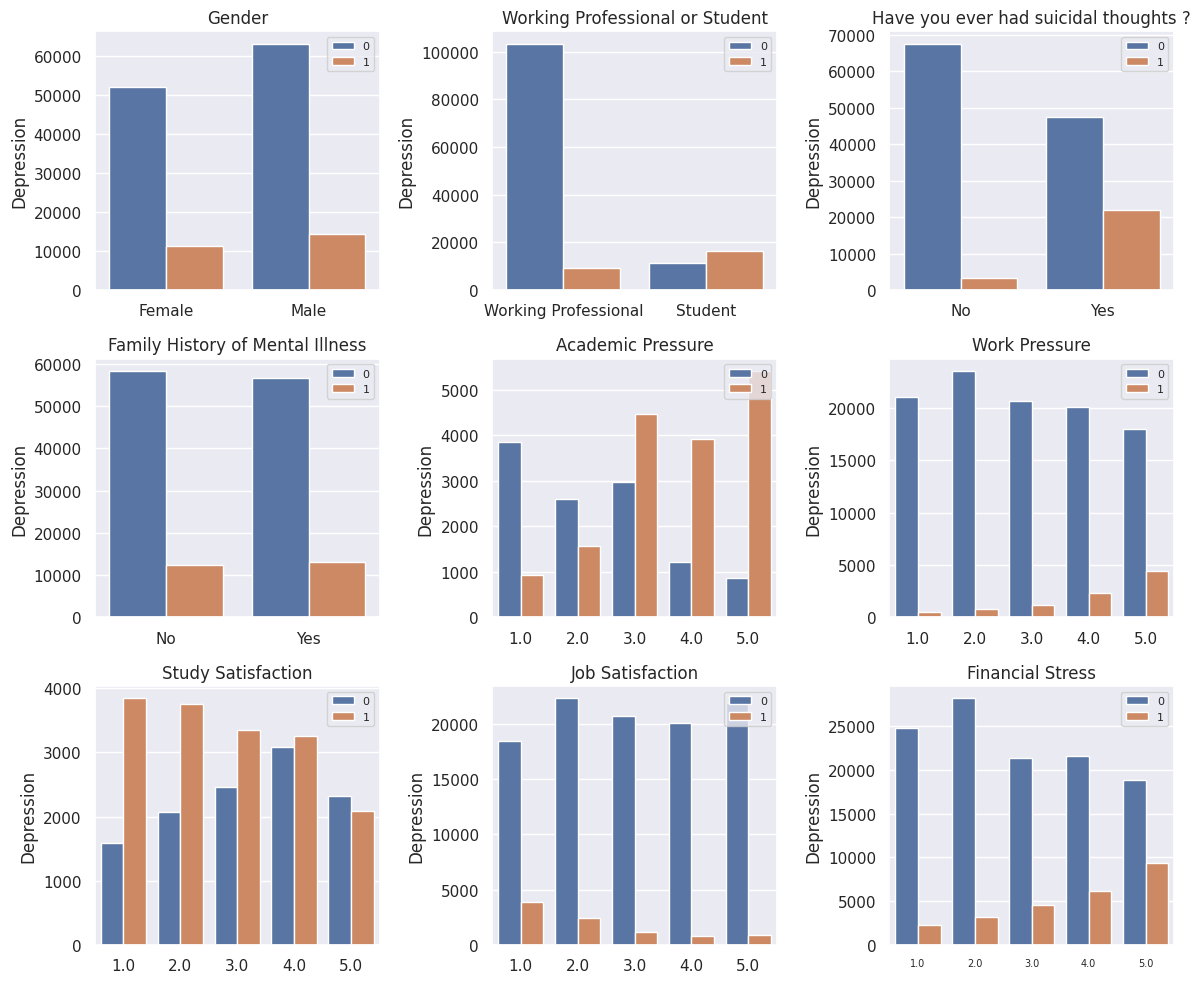

In [ ]:
#2 Visual insights
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()
fig, ax =plt.subplots(3,3, figsize=(12,10))
fig.subplots_adjust(wspace=0.3, hspace=0.7)
#Columns to analyse for visual insights

for col, subplot in zip(FEATURES_WITH_LESS_UNIQUE_VALUES, ax.flatten()):

  sns.countplot(ax=subplot, data =dsTrain, x=col, hue='Depression')
  subplot.legend(loc=1, prop={'size': 8})
  subplot.title.set_text(col )
  subplot.set_ylabel(TARGET)
  subplot.set_xlabel('')
  plt.xticks(fontsize=7)

plt.tight_layout()
plt.show()


Visual insights contd...


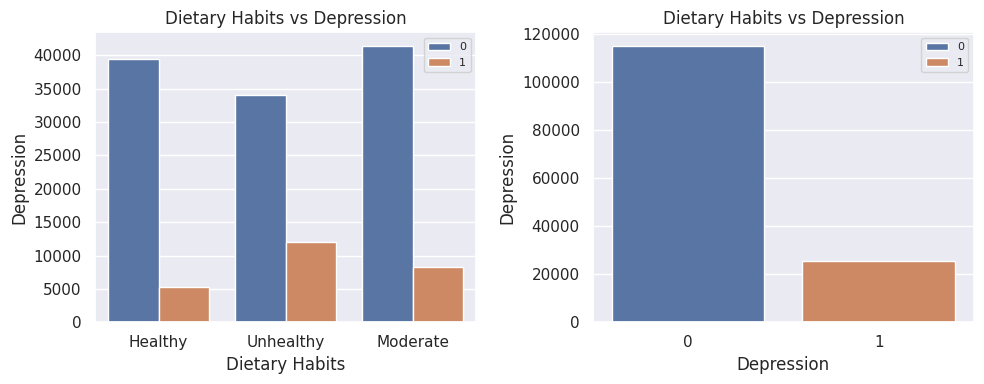

[Text(0, 0, '0'), Text(1, 0, '1')]
Empty DataFrame
Columns: [id, Name, Gender, Age, City, Working Professional or Student, Profession, Academic Pressure, Work Pressure, CGPA, Study Satisfaction, Job Satisfaction, Sleep Duration, Dietary Habits, Degree, Have you ever had suicidal thoughts ?, Work/Study Hours, Financial Stress, Family History of Mental Illness, Depression]
Index: []


In [ ]:
filteredData = dsTrain.loc[dsTrain['Dietary Habits'].isin(DIETARY_HABITS)]
fig, ax =plt.subplots(1,2, figsize=(10,4))
#ig.subplots_adjust(wspace=0.3, hspace=0.7)
#Columns to analyse for visual insights
#for col, subplot in zip(FEATURES_WITH_MORE_UNIQUE_VALUES, ax.flatten()):
fig.subplots_adjust(wspace=2.0)
subplot = sns.countplot( ax= ax[0],data=filteredData, x='Dietary Habits', hue='Depression')
subplot.legend(loc=1, prop={'size': 8})
subplot.title.set_text('Dietary Habits' + ' vs ' + TARGET)
subplot.set_ylabel(TARGET)

subplot = sns.countplot( ax= ax[1],data=filteredData, x=TARGET, hue='Depression')
subplot.legend(loc=1, prop={'size': 8})
subplot.title.set_text('Dietary Habits' + ' vs ' + TARGET)
subplot.set_ylabel(TARGET)

plt.tight_layout()
plt.show()

print(subplot.get_xticklabels())
print(filteredData[filteredData['Dietary Habits']=='Yes'])

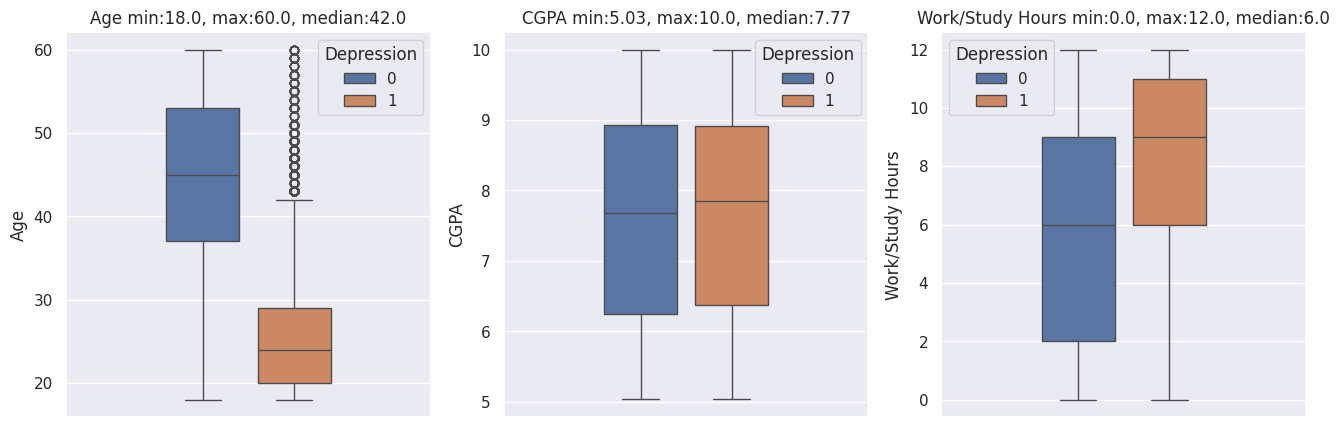

In [ ]:
#Box plots for numerical features in realtion to the target
fig, ax =plt.subplots(1,3, figsize=(16,5))

for col, subplot in zip(NUM_FEATURES, ax.flatten()):
  sns.boxplot(data=dsTrain,y= col , hue = TARGET, ax=subplot, width=0.5, gap=0.2)
  subplot.set_title(f'{col} min:{dsTrain[col].min()}, max:{dsTrain[col].max()}, median:{dsTrain[col].median()}')

plt.show()

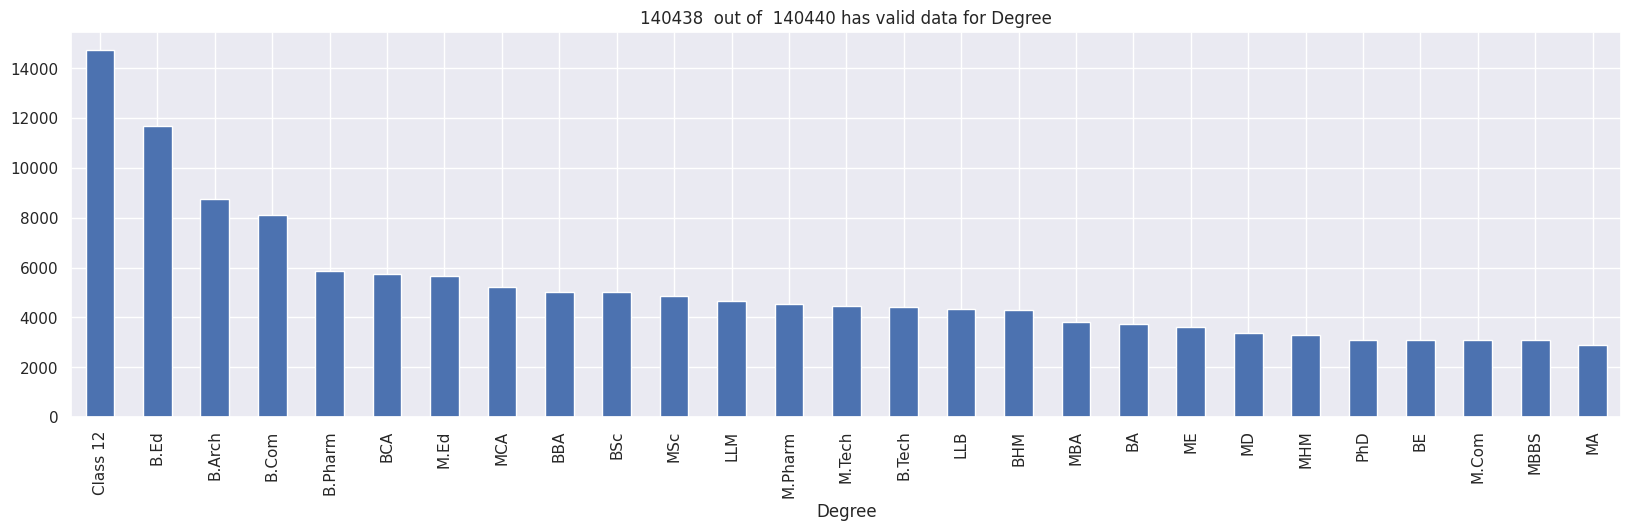

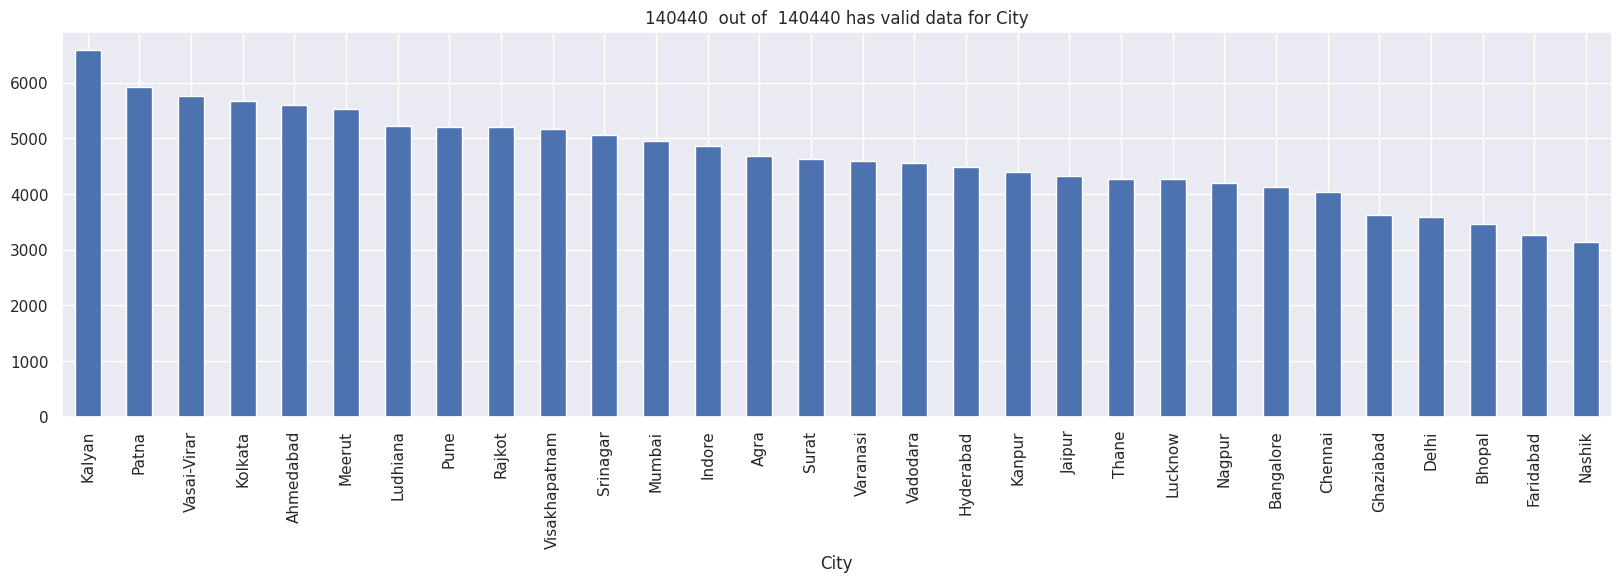

In [ ]:
#Bar plots representing the high cardinality categorical features
grps =dsTrain.groupby("Degree").filter(lambda x: len(x) > 5)
heading = f'{len(grps)}  out of  {len(dsTrain)} has valid data for Degree'
fig , ax = plt.subplots(figsize=(20, 5))
dsTrain['Degree'].value_counts().plot(kind='bar', y='Degree', x='count')
plt.title(heading)
plt.show()


grps =dsTrain.groupby("City").filter(lambda x: len(x) > 5)
heading = f'{len(grps)}  out of  {len(dsTrain)} has valid data for City'
fig , ax = plt.subplots(figsize=(20, 5))
dsTrain['City'].value_counts().plot(kind='bar', y='City', x='count')
plt.title(heading)
plt.show()


#Data Preprocessing

---



In [ ]:
import numpy as np
#3. This function processes and prepares the data ready for ML algorithm
def wrangle(ds):

  ds['Pressure'] = np.where(ds['Working Professional or Student']=='Student',
                    np.where(ds['Academic Pressure'].notnull(), ds['Academic Pressure'],ds['Work Pressure']),
                    ds['Work Pressure'])
  ds['Pressure'] = np.where(ds['Working Professional or Student']!='Student',
                    np.where(ds['Work Pressure'].notnull(), ds['Work Pressure'],ds['Academic Pressure']),
                    ds['Academic Pressure'])
  ds['Satisfaction'] = np.where(ds['Working Professional or Student']=='Student',
                    np.where(ds['Study Satisfaction'].notnull(), ds['Study Satisfaction'],ds['Job Satisfaction']),
                    ds['Job Satisfaction'])
  ds['Satisfaction'] = np.where(ds['Working Professional or Student']!='Student',
                    np.where(ds['Job Satisfaction'].notnull(), ds['Job Satisfaction'],ds['Study Satisfaction']),
                    ds['Study Satisfaction'])
  dsRet= ds.drop(["id", "Name", "Work Pressure", "Academic Pressure", "Job Satisfaction","Study Satisfaction" ], axis= 1)

  if LGBM :
    for col in CAT_FEATURES:
      dsRet[col]=dsRet[col].astype('category')
  else:
    for col in CAT_FEATURES:
      dsRet[col]=dsRet[col].astype(str)


  return dsRet

CAT_FEATURES.append('Pressure')
CAT_FEATURES.append('Satisfaction')
CAT_FEATURES.remove('Work Pressure')
CAT_FEATURES.remove('Academic Pressure')
CAT_FEATURES.remove('Job Satisfaction')
CAT_FEATURES.remove('Study Satisfaction')

processed_Train=wrangle(dsTrain)


#Split the data to train and validation

In [ ]:
#Split train and val data
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

y=processed_Train[TARGET]
X=processed_Train.drop(TARGET, axis = 1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=40)


#Train the model with CATBoost

In [ ]:
catFeatureIndices = [X_train.columns.get_loc(col) for col in CAT_FEATURES]

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from matplotlib import pyplot as plt
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

trainingPool = Pool(X_train, label=y_train, cat_features=catFeatureIndices)
valPool = Pool(X_val, label=y_val,cat_features=catFeatureIndices)

model = CatBoostClassifier()

model.fit(trainingPool)



#Train the model with LGBM

In [ ]:
import lightgbm as lgbm
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

encoder = CatBoostEncoder()
# Fit the encoder on the training data
encoder.fit(X_train, y_train)
# Encode categorical variables
X_train_encoded = encoder.transform(X_train)
X_val_encoded = encoder.transform(X_val)

model= lgbm.LGBMClassifier()
model.fit(X=X_train_encoded, y  = y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 17831, number of negative: 80659
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 462
[LightGBM] [Info] Number of data points in the train set: 98490, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181044 -> initscore=-1.509292
[LightGBM] [Info] Start training from score -1.509292


LGBMClassifier()

In [ ]:
# predicting for validation data
if LGBM :
  print ('Report for training data')
  pred=model.predict(X_train_encoded)
  report= classification_report(y_train, pred)
  print(report)
  print ('Report for testing data')
  pred=model.predict(X_val_encoded)
  report= classification_report(y_val, pred)

else:
  print ('Report for training data')
  pred=model.predict(trainingPool)
  report= classification_report(y_train, pred)
  print(report)

  print ('Report for testing data')
  pred=model.predict(valPool)
  report= classification_report(y_val, pred)
print(report)



Report for training data
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     80659
           1       0.86      0.84      0.85     17831

    accuracy                           0.94     98490
   macro avg       0.91      0.90      0.91     98490
weighted avg       0.94      0.94      0.94     98490

Report for testing data
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     34474
           1       0.84      0.82      0.83      7736

    accuracy                           0.94     42210
   macro avg       0.90      0.89      0.90     42210
weighted avg       0.94      0.94      0.94     42210



LGBMClassifier


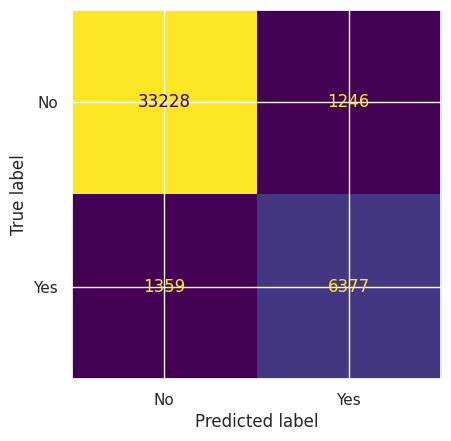

In [ ]:
#Confusion matrix diaplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cmatrix =confusion_matrix(y_val, pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cmatrix, display_labels = ['No', 'Yes'])
subplot = cm_display.plot( colorbar=False)
print(type(model).__name__)
plt.show()

In [ ]:
#Function to calculate the auc
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
def calculateROC(model):
  if LGBM :
    Y_prob=model.predict_proba(X_val_encoded)
  else :
    Y_prob=model.predict_proba(X_val)
  fpr, tpr, thresold =roc_curve(y_val, Y_prob[:,1])
  roc_auc=auc(fpr,tpr)
  plt.plot(fpr, tpr, label =f'{type(model)} with roc_auc{roc_auc:.2f}')

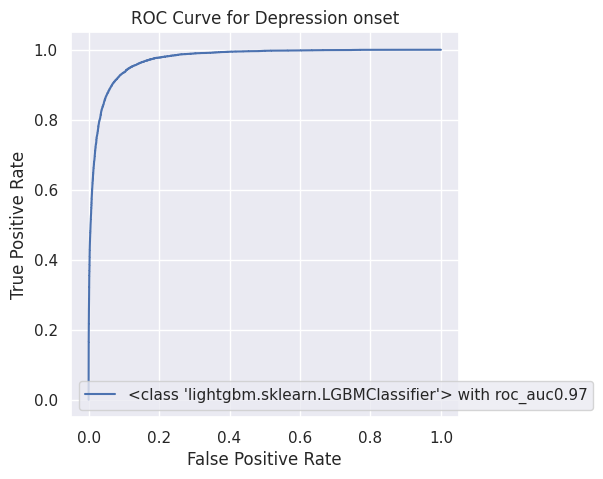

In [ ]:
#5 plot the roc
plt.figure(figsize=(5,5), dpi=100)
calculateROC(model)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Depression onset')
plt.legend()
plt.show()

#Hyperparameter tunning with Optuna

In [ ]:
#Optuna has a objecctive function and the number of trials involved as param
#A study with the objective is created which focuses on optimizing the
#objective functions return value, which is accracy in this case.
import optuna
from sklearn.metrics import classification_report
def Objective(trial):
  params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 3, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain'])
    }
  trainingPool = Pool(X_train, label=y_train, cat_features=catFeatureIndices)
  valPool = Pool(X_val, label=y_val,cat_features=catFeatureIndices)

  catModel= CatBoostClassifier(**params, silent=True)
  catModel.fit(trainingPool)
  pred=catModel.predict(valPool)
  report= classification_report(y_val, pred, output_dict=True)
  f1score=report['0']['f1-score'] #Focus on false nagative
  accuracy = accuracy_score(y_val,pred)
  return accuracy

study = optuna.create_study(directions=['maximize'])
study.optimize(Objective, n_trials=30)

[I 2024-11-14 00:07:39,726] A new study created in memory with name: no-name-32c2f69b-54a0-4df2-8e71-5c4ad096c322
[I 2024-11-14 00:11:25,405] Trial 0 finished with value: 0.9390191897654584 and parameters: {'learning_rate': 0.020221994099713196, 'depth': 6, 'min_data_in_leaf': 86, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.9390191897654584.
[I 2024-11-14 00:14:23,479] Trial 1 finished with value: 0.9389007344231225 and parameters: {'learning_rate': 0.017369558784876848, 'depth': 5, 'min_data_in_leaf': 35, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.9390191897654584.
[I 2024-11-14 00:23:47,099] Trial 2 finished with value: 0.9396588486140725 and parameters: {'learning_rate': 0.04699468791489697, 'depth': 8, 'min_data_in_leaf': 48, 'boosting_type': 'Ordered'}. Best is trial 2 with value: 0.9396588486140725.
[I 2024-11-14 00:28:12,253] Trial 3 finished with value: 0.9394219379294007 and parameters: {'learning_rate': 0.06437295007347922, 'depth': 7, 'min_data_in_

In [ ]:

print('Best hyperparameters:', study.best_params)
print('Best Accuracy:', study.best_value)

#Find the optimal thresold with ROC

In [ ]:
print(model.get_probability_threshold())
model.set_probability_threshold(0.5)
pred=model.predict(valPool)
accuracy = accuracy_score(y_val,pred)
print(round(accuracy*100,2))
pred = model.predict(trainingPool)
accuracy = accuracy_score(y_train,pred)
print("TRainning accuracy", accuracy)

#Predict for test data

In [ ]:
#Prediction for test data
dsTest.info()
processed_Test = wrangle(dsTest)
encoded_Test =encoder.transform(processed_Test)
yPred =model.predict(encoded_Test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93800 entries, 0 to 93799
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     93800 non-null  int64  
 1   Name                                   93800 non-null  object 
 2   Gender                                 93800 non-null  object 
 3   Age                                    93800 non-null  float64
 4   City                                   93800 non-null  object 
 5   Working Professional or Student        93800 non-null  object 
 6   Profession                             69168 non-null  object 
 7   Academic Pressure                      18767 non-null  float64
 8   Work Pressure                          75022 non-null  float64
 9   CGPA                                   18766 non-null  float64
 10  Study Satisfaction                     18767 non-null  float64
 11  Jo

#predictions in a csv file for submission

In [ ]:

submission = pd.DataFrame(dsTest['id'])
submission[TARGET]=yPred
submission.to_csv('result.csv',index= False)


#Feature Importance

Age                                      30.687840
Have you ever had suicidal thoughts ?    17.187376
Pressure                                 10.430433
Financial Stress                          8.473645
Satisfaction                              6.141189
Work/Study Hours                          5.260653
CGPA                                      3.971722
Profession                                3.633171
Dietary Habits                            3.344588
City                                      2.858119
Working Professional or Student           2.796944
Sleep Duration                            2.178605
Degree                                    2.049786
Family History of Mental Illness          0.637054
Gender                                    0.348877
dtype: float64


<Axes: >

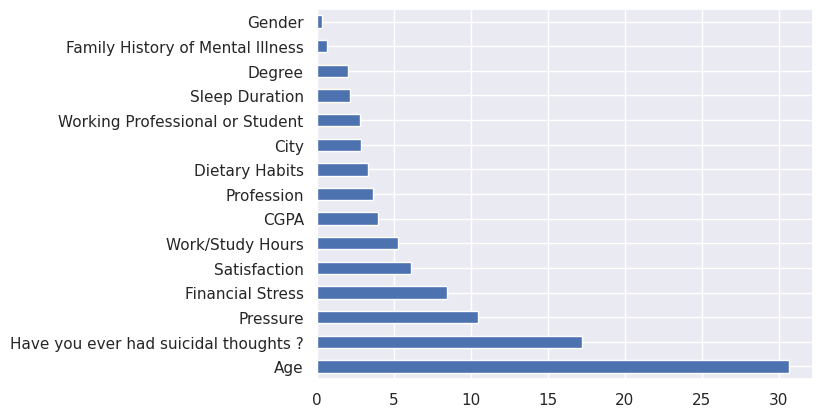

In [ ]:
features = pd.Series(model.feature_importances_, index = X_train.columns)

print(features.sort_values(ascending=False))

#features.nlargest(10).plot.barh(y=features.index)
features.sort_values(ascending=False).plot.barh(y=features.index)